# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

**Authors:** first_name_1 last_name_1, first_name_2 last_name_2, first_name_3 last_name_3  
**Due date:** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [278]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

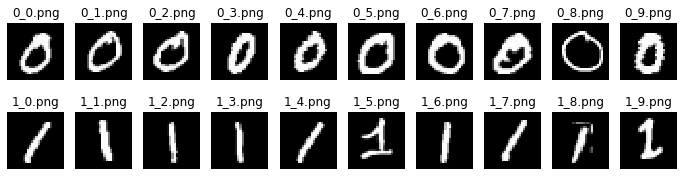

In [279]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

In [280]:
import numpy as np
from scipy.optimize import curve_fit
import cv2
from sklearn.cluster import KMeans, SpectralClustering
from scipy import ndimage
from sklearn.mixture import GaussianMixture
from skimage import measure

In [281]:
images = np.append(zeros_im,ones_im,axis = 0)

### 1.2 Fourier descriptors
Add your implementation and discussion

In [282]:
def low_pass_filter(img,size):
    Kernel = np.ones((size,size),np.float32)/size**2
    return ndimage.filters.convolve(img, Kernel)

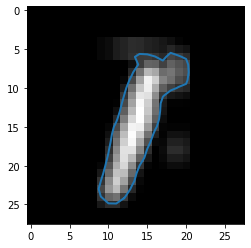

In [283]:
fig, ax = plt.subplots()
im = ones_im[8]
im = low_pass_filter(im,3)
contours = measure.find_contours(im, 50)
ax.imshow(im, cmap=plt.cm.gray)
for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

In [284]:
def get_ordered_contour(im):
    '''
    Contour detection function based on the simple images we have.
    
    Input: grayscale image
    Output: contour of the main feature ( In our application, handwritten digits )
    
    '''
    im = im = low_pass_filter(im,3)
    contours = measure.find_contours(im, 50)
    contours_array = []
    for n, contour in enumerate(contours):
        for x,y in contour:
            contours_array.append((x,y))
    contours_array = np.array(contours_array).astype(int)
        
    return contours_array

#### Create the complex number from the detected contour:   $ u_k = x_k + j*y_k $

In [334]:
def complex_contour_vector(img):

    contour_array = get_ordered_contour(img)
    contour_img = np.zeros(img.shape)
    uk = []
    
    for k in contour_array:
        uk.append(np.vectorize(complex)(k[0],k[1]))
        contour_img[k[0],k[1]] = 1
    uk = np.array(uk)
    
    return uk, contour_img

#### Compute and plot DFT (FFT) : 

In [296]:
def dft_computation(img,n_descriptor=2):
    uk, contour_img = complex_contour_vector(img)
    sp = np.fft.fft(uk)
    freq = np.fft.fftfreq(len(uk))
    
    return sp[1:1+n_descriptor],contour_img

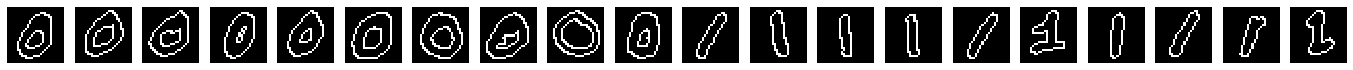

In [331]:
fig, axes = plt.subplots(1, len(images), figsize=(24, 3))
for ax, im in zip(axes, images):
    sp, contour  = dft_computation(im)
    ax.imshow(contour, cmap='gray')
    ax.axis('off')

#### Classify according to the two selected features

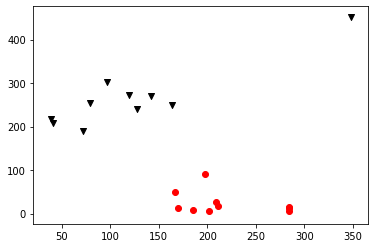

In [332]:
features = []
contours = []
images = np.append(zeros_im,ones_im,axis = 0)
for im in images:
    sp,contour = dft_computation(im)
    features.append(sp)
    contours.append(contour)
features = np.array(features)
X = np.append(features.real,features.imag,axis=1)
features = np.absolute(features)

kmeans = KMeans(n_clusters=2, random_state=0).fit(features)
kmeans.labels_
LABEL_COLOR_MAP = {0 : 'r', 1 : 'k'}
MARKER_MAP = {0 : 'v', 1: 'o', 2: '*', 3:'X'}
markers = [MARKER_MAP[i//10] for i in range(images.shape[0])]
label_color = [LABEL_COLOR_MAP[l] for l in kmeans.labels_]

fig, ax = plt.subplots()
for xp, yp, color, m in zip(features[:,0], features[:,1], label_color, markers):
    ax.scatter([xp],[yp],c = color, marker=m)
plt.show()

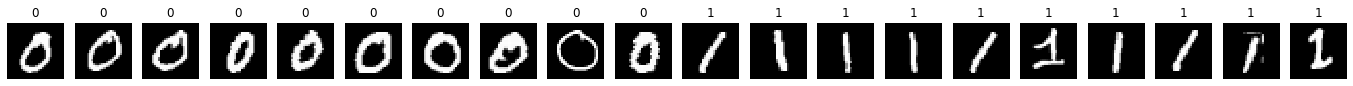

In [333]:
LABEL_NAME_MAP =  {1 : '0', 0 : '1'}
img_name = [LABEL_NAME_MAP[l] for l in kmeans.labels_]

fig, axes = plt.subplots(1, len(images), figsize=(24, 3))
for ax, im, nm in zip(axes, images, img_name):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.3 Additional method(s)
Add your implementation and discussion

# Distance between contours

# Chain code

# Edition distance

# Region-based descriptors 

## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

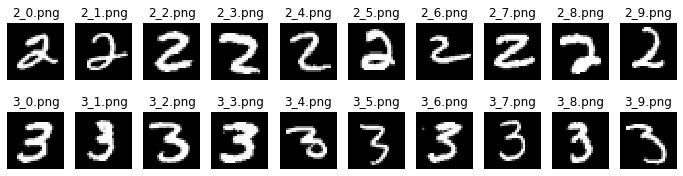

In [300]:
#  Load zeros
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])
twos_im = skimage.io.concatenate_images(ic)
#  Load ones
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))
threes_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Additional method(s) and conclusion
Add your implementations and discussions here

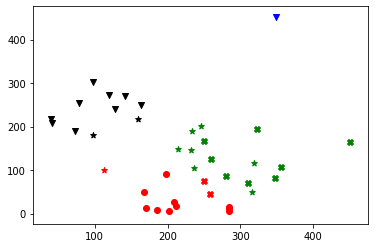

In [322]:
features = []
contours = []
images = np.append(zeros_im,ones_im,axis = 0)
images = np.append(images,twos_im,axis = 0)
images = np.append(images,threes_im,axis = 0)
#images = np.append(twos_im,threes_im,axis = 0)

for im in images:
    sp,contour = dft_computation(im)
    features.append(sp)
    contours.append(contour)
features = np.array(features)
X = np.append(features.real,features.imag,axis=1)
features = np.absolute(features)

kmeans = KMeans(n_clusters=4, random_state=0).fit(features)
kmeans.labels_
LABEL_COLOR_MAP = {0 : 'r', 1 : 'k', 2: 'b', 3: 'g'}
LABEL_NAME_MAP =  {0 : '1', 1 : '0', 2 : 'Outlier', 3 : '2/3'}
MARKER_MAP = {0 : 'v', 1: 'o', 2: '*', 3:'X'}
markers = [MARKER_MAP[i//10] for i in range(images.shape[0])]
label_color = [LABEL_COLOR_MAP[l] for l in kmeans.labels_]

fig, ax = plt.subplots()
for xp, yp, color, m in zip(features[:,0], features[:,1], label_color, markers):
    ax.scatter([xp],[yp],c = color, marker=m)
plt.show()

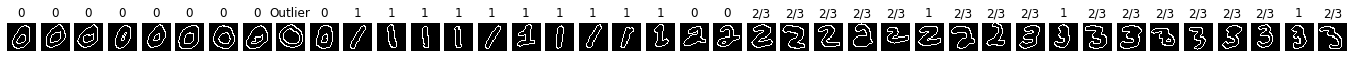

In [323]:
img_name = [LABEL_NAME_MAP[l] for l in kmeans.labels_]

fig, axes = plt.subplots(1, len(images), figsize=(24, 3))

for ax, im, nm in zip(axes, contours, img_name):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)